In [35]:
# !pip install opencv-python pydotplus six graphviz

In [36]:
# importamos las librerias necesarias
import sys
assert sys.version_info >= (3, 5)
import os
import pandas as pd
import numpy as np
import seaborn as sns

In [37]:
import matplotlib.pyplot as plt

In [38]:
import numpy as np 
# Estandarizador (transforma las variables en z-scores)
from sklearn.preprocessing import StandardScaler
std_scale = StandardScaler() # Creamos el estandarizador para usarlo posteriormente

In [39]:
DATA_PATH = "../data"
def load_data_prep(data_path=DATA_PATH):
    csv_path = os.path.join(data_path, "train_set_limpio.csv")
    return pd.read_csv(csv_path)

def load_data_test(data_path=DATA_PATH):
    csv_path = os.path.join(data_path, "test_set_limpio.csv")
    return pd.read_csv(csv_path)

In [40]:
train_set = load_data_prep()
test_set = load_data_test()
test_set.shape, train_set.shape

((13, 291), (52, 292))

In [41]:
test_set.loc[test_set.cod.str.contains('sub-500'),'label'] = '1'
test_set.loc[test_set.cod.str.contains('sub-10'),'label'] = '0'
print(test_set[['cod','label']])

          cod label
0   sub-10438     0
1   sub-10487     0
2   sub-50004     1
3   sub-10345     0
4   sub-50010     1
5   sub-10492     0
6   sub-50033     1
7   sub-50025     1
8   sub-10523     0
9   sub-10235     0
10  sub-10273     0
11  sub-50020     1
12  sub-10325     0


In [42]:
X_train = train_set.drop(['cod', 'label'], axis=1)
X_test = test_set.drop(['cod', 'label'], axis=1)
y_test = test_set['label']
y_train = train_set['label']
X_train.shape, X_test.shape, y_test.shape, y_train.shape


((52, 290), (13, 290), (13,), (52,))

In [43]:
# Ajustamos el estandarizador
std_scale.fit(X_test)
std_scale.fit(X_train)

# Aplicamos el estandarizador y obtenemos la matriz de features escaleados
X_test_scaled = std_scale.transform(X_test)
X_scaled = std_scale.transform(X_train)

In [44]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
# instanciemos el modelo y entremoslo en el conjunto de autos
arbol = DecisionTreeClassifier(criterion='gini', max_depth=3, min_samples_leaf=1, min_samples_split=2, ccp_alpha=0)
arbol.fit(X_scaled,y_train)
accuracy_score(y_train, arbol.predict(X_scaled))

1.0

In [45]:
# veamos que tan bien le fue a este modelo
y_test = y_test.astype(y_train.dtype)
print(classification_report(y_true=y_test,y_pred=arbol.predict(X_test_scaled)))

              precision    recall  f1-score   support

           0       0.64      0.88      0.74         8
           1       0.50      0.20      0.29         5

    accuracy                           0.62        13
   macro avg       0.57      0.54      0.51        13
weighted avg       0.58      0.62      0.56        13



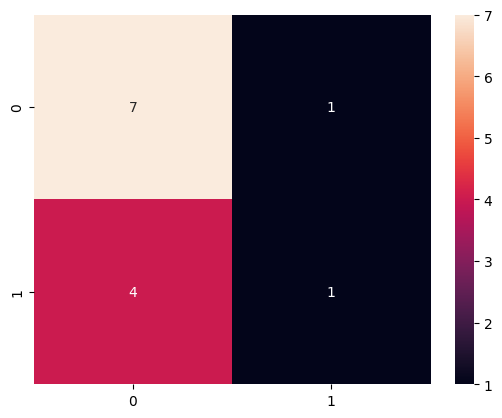

In [46]:
cf_matrix = confusion_matrix(y_test, arbol.predict(X_test_scaled))
sns.heatmap(cf_matrix, annot=True);

## Feature importance

Los árboles nos permiten definir una manera de medir la importancia de los features (o *Feature Importances*) basado en la ganancia de información obtenida cada vez que se utilizo cada feature para hacer un split. Para esto, una vez entrando el árbol, el método que utilizaremos es: 

```
# arbol.feature_importances_
```

In [47]:
# calculando las 5 feature importances mas altas
importances = pd.Series(arbol.feature_importances_).sort_values(ascending=False)[:10]
importances

181    0.555930
152    0.148693
110    0.139037
226    0.099695
87     0.056645
186    0.000000
187    0.000000
185    0.000000
188    0.000000
189    0.000000
dtype: float64

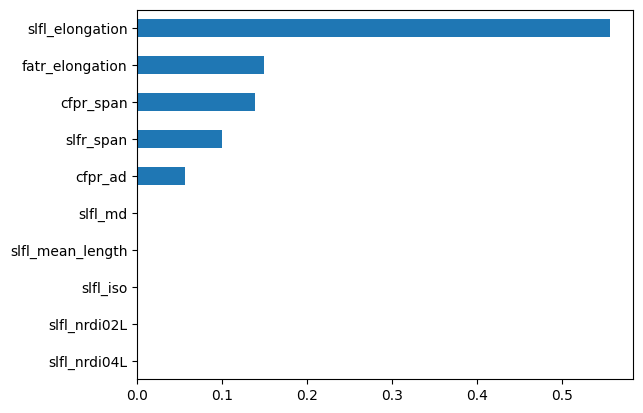

In [48]:
f5_names = list(pd.Series(X_test.columns)[importances.index.to_list()])
fig, ax = plt.subplots()
importances.plot.barh(ax=ax)
ax.set_yticklabels(f5_names)
ax.invert_yaxis()

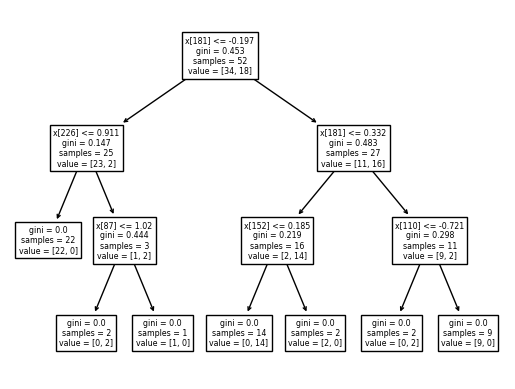

In [49]:
plot_tree(arbol);


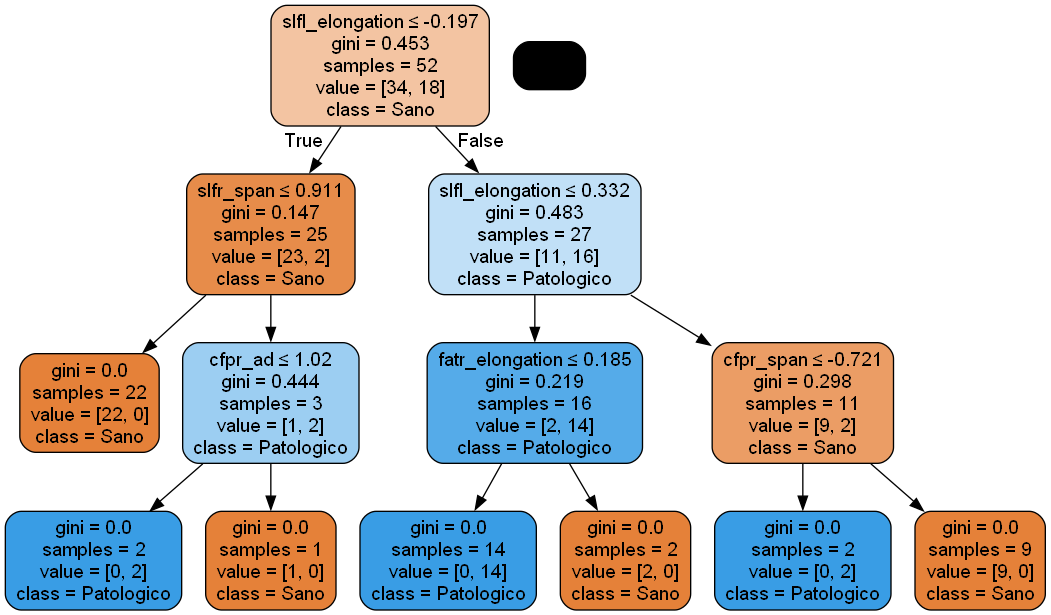

In [50]:
# libreria
#from sklearn.externals.six import StringIO 
from six import StringIO 
from IPython.display import Image 
from sklearn.tree import export_graphviz
import pydotplus
import matplotlib.pyplot as plt

dot_data = StringIO()
export_graphviz(arbol, out_file=dot_data,
                feature_names=X_train.columns,
                class_names=["Sano","Patologico"],  
                filled=True, rounded=True,
                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

Overfitting: profundidad del árbol y post-pruning

Dado que los árboles son modelos que tienden a overfittear tenemos que recurrir a distintas técnicas para mitigar este problema. Veamos primero el efecto de la profundidad del árbol en el trade-off sesgo varianza.

In [51]:
profundidad = list(range(1,20))
resultados_train = []
resultados_test  = []

for depth in profundidad:
    # instanciamos el modelo uniforme
    arbol = DecisionTreeClassifier(criterion='gini', max_depth=depth, min_samples_leaf=1, min_samples_split=2, ccp_alpha=0, class_weight="balanced")
    arbol.fit(X_scaled, y_train)
    y_train_pred = arbol.predict(X_scaled)
    y_pred = arbol.predict(X_test_scaled)
    resultados_train.append(accuracy_score(y_train, y_train_pred))
    resultados_test.append(accuracy_score(y_test, y_pred))

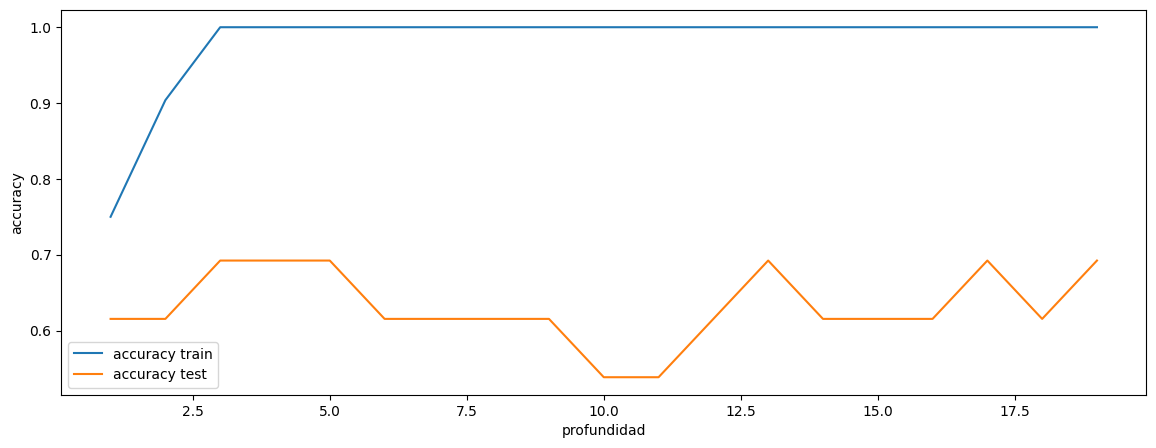

In [52]:
# veamos que paso en cada caso
f, ax = plt.subplots(1,1,figsize=(14,5),sharey=True)
ax.plot(profundidad, resultados_train, profundidad, resultados_test);
ax.legend(['accuracy train', 'accuracy test']);
ax.set(xlabel='profundidad',ylabel='accuracy');

In [53]:
# veamos que pasa con un árbol sin corte de profundidad
arbol = DecisionTreeClassifier(criterion='gini', ccp_alpha=0)
arbol.fit(X_scaled, y_train)
#print(classification_report(y_true=y_test,y_pred=arbol.predict(X_test)))
print('Accuracy en entrenamiento: %f' % accuracy_score(y_train,arbol.predict(X_scaled)))
print('Accuracy en test: %f' % accuracy_score(y_test,arbol.predict(X_test_scaled)))

Accuracy en entrenamiento: 1.000000
Accuracy en test: 0.615385


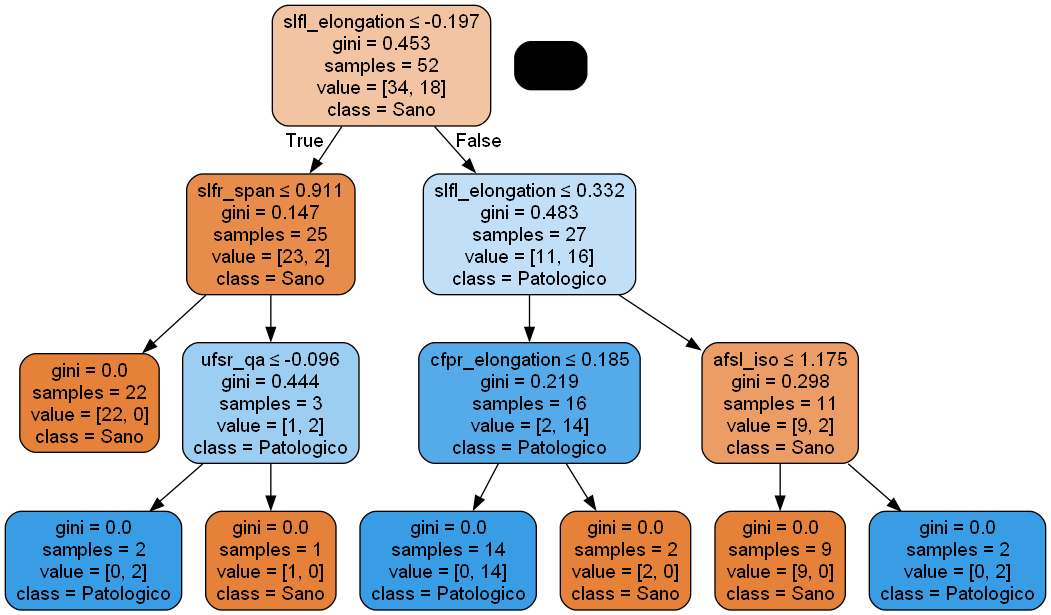

In [54]:
# grafiquemos este árbol
dot_data = StringIO()
export_graphviz(arbol, out_file=dot_data,
                feature_names=X_train.columns,
                class_names=["Sano","Patologico"],    
                filled=True, rounded=True,
                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

Una técnica que nos permite mitigar el overfitting es lo que se conoce como post-prunning. El objetivo de esta técnica es *podar* el árbol entrenado, penalizando de alguna forma los árboles más complejos. El algortimo de poda que tenemos implementado en Scikit-Learn es el [Minimal Cost-Complexity Pruning](https://scikit-learn.org/stable/modules/tree.html#minimal-cost-complexity-pruning). El hiperparámetro que controla esta penalización es ccp_alpha$\geq 0$, cuando este hiperparámetro es 0, no realizamos ningún tipo de poda, y a medida que aumentamos dicho hiperparámetro penalizaremos más fuertemente la cantidad de nodos terminales del árbol.

In [55]:
arbol = DecisionTreeClassifier(criterion='gini', ccp_alpha=0.05)
arbol.fit(X_scaled, y_train)
#print(classification_report(y_true=y_test,y_pred=arbol.predict(X_test)))
print('Accuracy en entrenamiento: %f' % accuracy_score(y_train,arbol.predict(X_scaled)))
print('Accuracy en test: %f' % accuracy_score(y_test,arbol.predict(X_test_scaled)))

Accuracy en entrenamiento: 0.961538
Accuracy en test: 0.538462


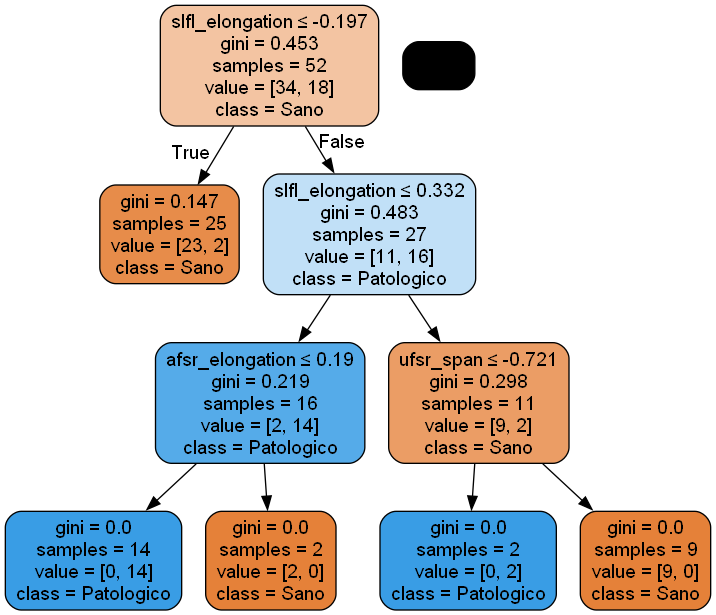

In [56]:
dot_data = StringIO()
export_graphviz(arbol, out_file=dot_data, 
                feature_names=X_train.columns,
                class_names=["Sano","Patologico"],   
                filled=True, rounded=True,
                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

In [57]:
# veamos como afecta el rendimiento y la profundidad del árbol
ccp_alpha_vals = np.arange(0,1,0.05)
resultados_train = []
resultados_test  = []
profundidad      = []

for ccp in ccp_alpha_vals:
    # instanciamos el modelo uniforme
    arbol = DecisionTreeClassifier(criterion='gini', ccp_alpha=ccp)
    arbol.fit(X_scaled, y_train)
    # guardamos la profundidad del árbol
    profundidad.append(arbol.tree_.max_depth)
    y_train_pred = arbol.predict(X_scaled)
    y_pred = arbol.predict(X_test_scaled)
    resultados_train.append(accuracy_score(y_train, y_train_pred))
    resultados_test.append(accuracy_score(y_test, y_pred))

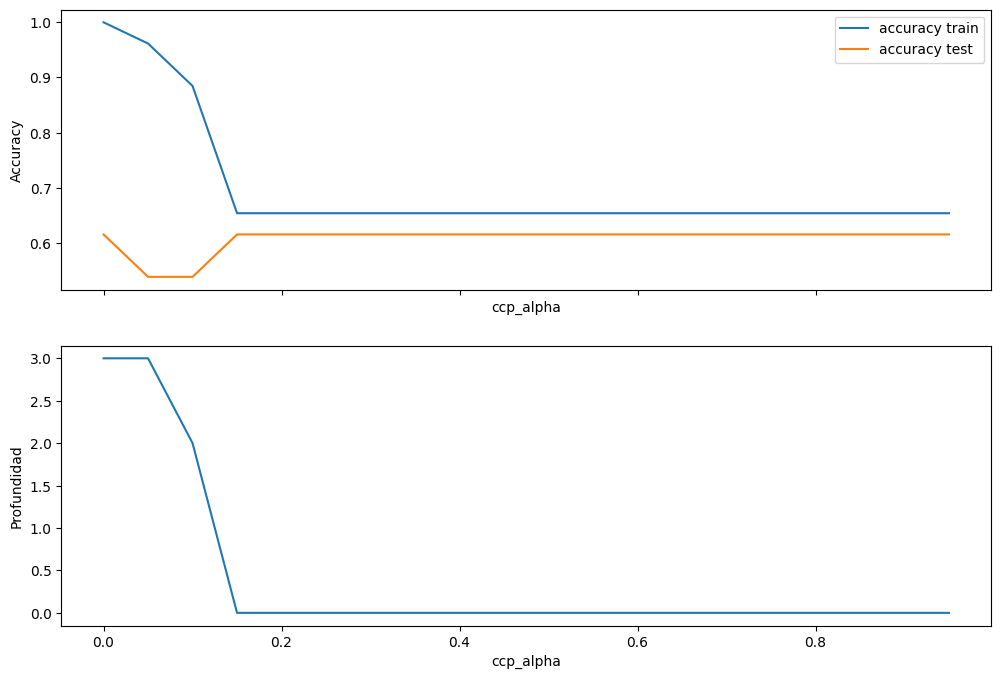

In [58]:
f,ax = plt.subplots(2,1,figsize=(12,8),sharex=True)
ax[0].plot(ccp_alpha_vals, resultados_train, ccp_alpha_vals, resultados_test);
ax[0].legend(['accuracy train', 'accuracy test']);
ax[0].set(xlabel='ccp_alpha',ylabel='Accuracy');
ax[1].plot(ccp_alpha_vals, profundidad)
ax[1].set(xlabel='ccp_alpha',ylabel='Profundidad');

In [61]:
ccp_alpha_vals

array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
       0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95])

In [68]:
arbol = DecisionTreeClassifier(criterion='gini', ccp_alpha=0.15)
arbol.fit(X_scaled, y_train)
#print(classification_report(y_true=y_test,y_pred=arbol.predict(X_test)))
print('Accuracy en entrenamiento: %f' % accuracy_score(y_train,arbol.predict(X_scaled)))
print('Accuracy en test: %f' % accuracy_score(y_test,arbol.predict(X_test_scaled)))

Accuracy en entrenamiento: 0.653846
Accuracy en test: 0.615385


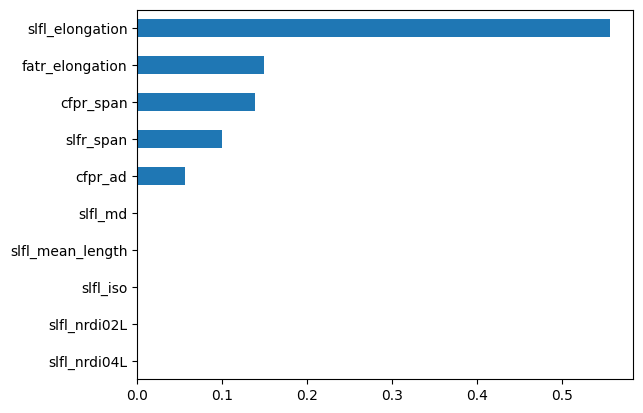

In [69]:
f5_names = list(pd.Series(X_test.columns)[importances.index.to_list()])
fig, ax = plt.subplots()
importances.plot.barh(ax=ax)
ax.set_yticklabels(f5_names)
ax.invert_yaxis()